In [ ]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [ ]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import *
from tensorflow.keras.layers import LayerNormalization
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt

Tensorflow version: 2.12.0


In [ ]:
df = pd.read_csv("/content/stockdata/IBM.csv")

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df.drop('Adj Close', inplace=True, axis=1)
df.sort_values('Date', inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume
15482,2023-07-06,133.240005,133.899994,131.550003,132.160004,3507700
15483,2023-07-07,131.779999,133.850006,131.750000,132.080002,2982400
15484,2023-07-10,131.759995,133.050003,131.699997,132.899994,2369200
15485,2023-07-11,133.660004,134.559998,133.229996,134.440002,2925200
15486,2023-07-12,135.070007,135.330002,132.570007,132.839996,3731800


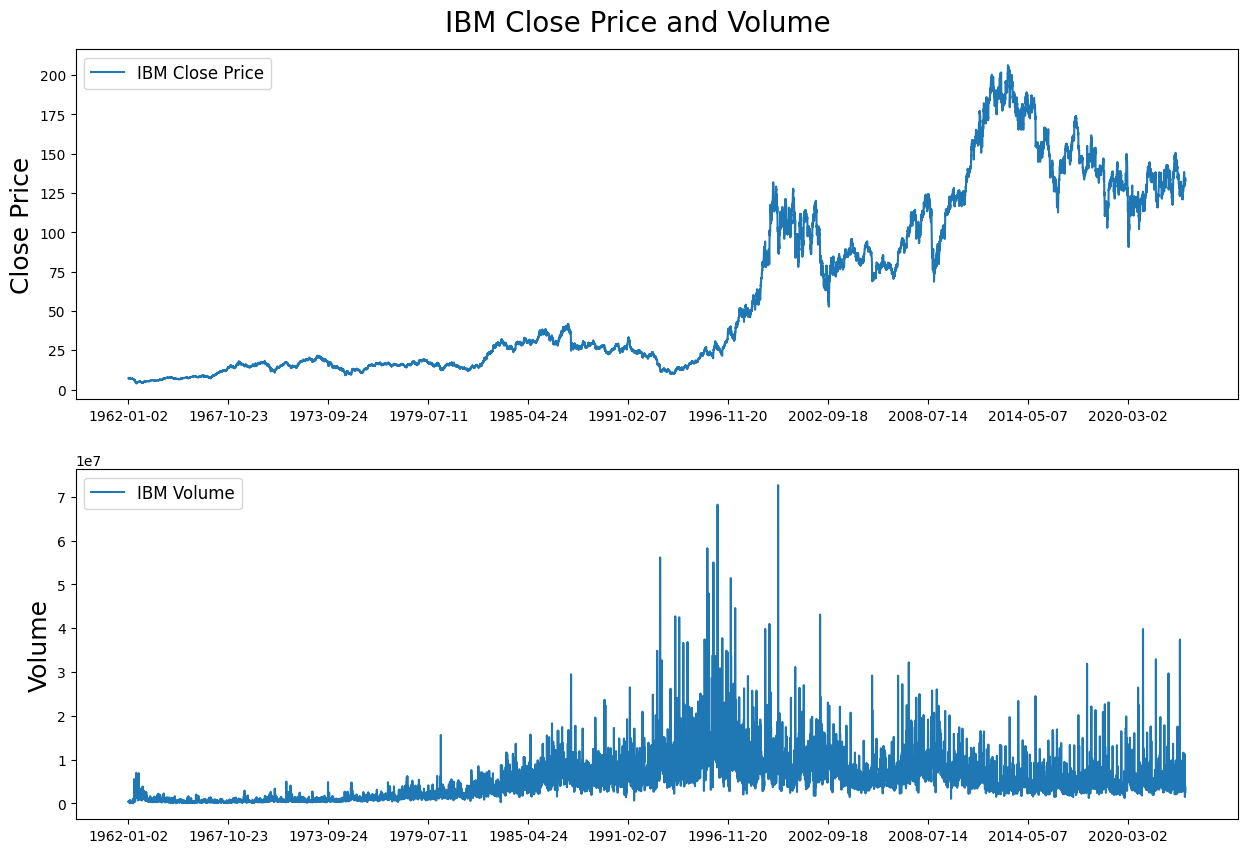

In [ ]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("IBM Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='IBM Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='IBM Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [ ]:
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))
print(min_return);
print(max_return);

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###########################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
df=df.values
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))
df_train.head()

3.824092
160.344162
Training data shape: (12390, 5)
Validation data shape: (1549, 5)
Test data shape: (1548, 5)


<ipython-input-8-c30d378f9a0f>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['Date'], inplace=True)
<ipython-input-8-c30d378f9a0f>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop(columns=['Date'], inplace=True)
<ipython-input-8-c30d378f9a0f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['Date'], inplace=True)


,Open,High,Low,Close,Volume
0,0.022681,0.022681,0.022152,0.022152,0.005294
1,0.022152,0.022559,0.022152,0.022559,0.003889
2,0.022559,0.022559,0.022070,0.022091,0.003457
3,0.022029,0.022029,0.021093,0.021174,0.004970
4,0.021134,0.021134,0.019953,0.020319,0.007562


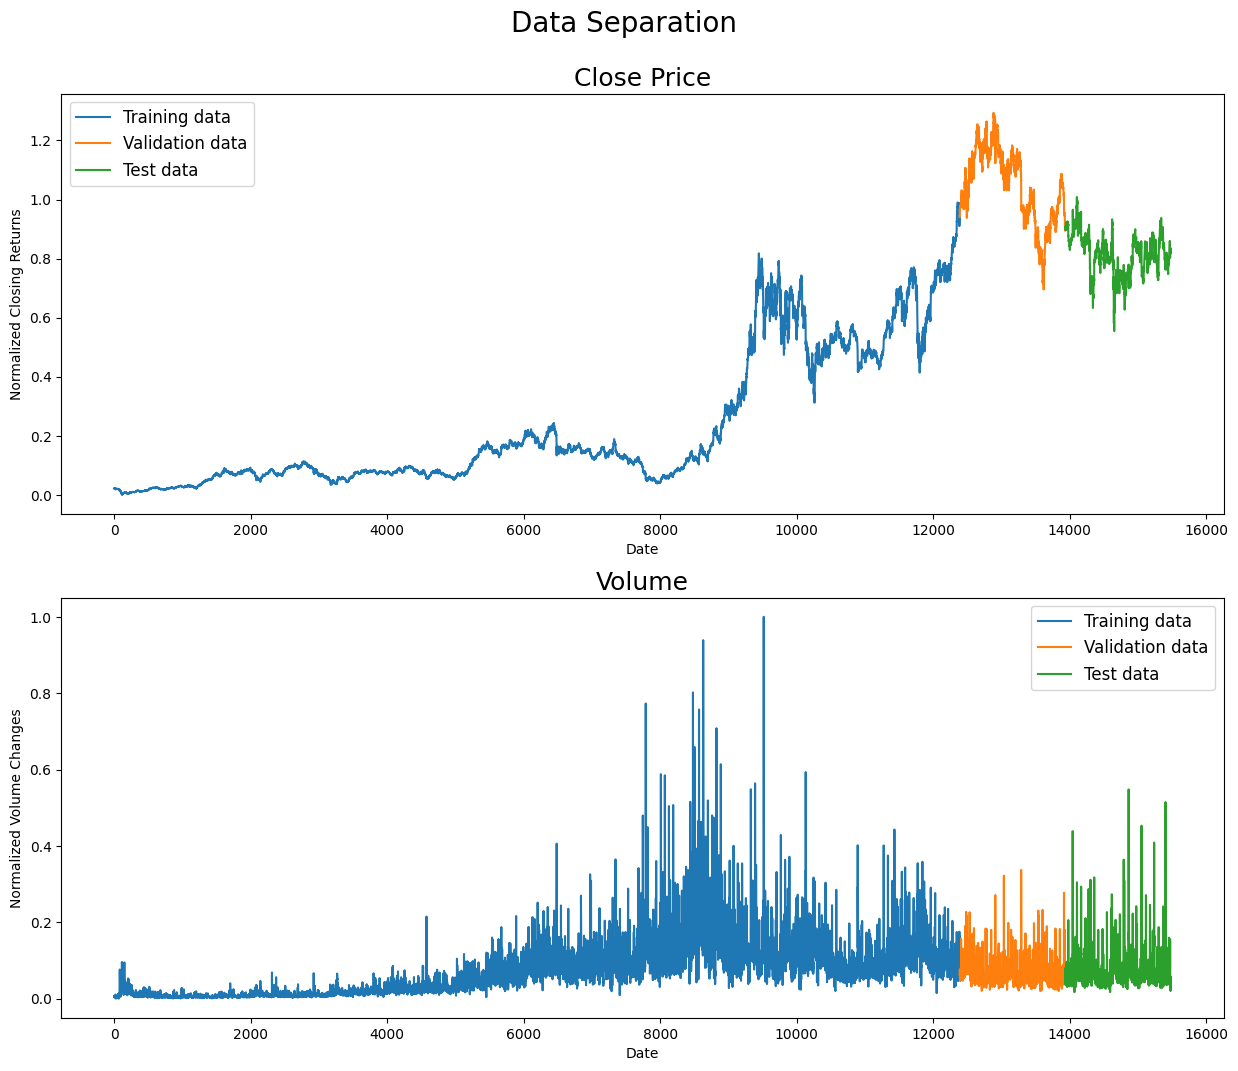

In [ ]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [ ]:
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)
y_test


Training set shape (12262, 128, 5) (12262,)
Validation set shape (1421, 128, 5) (1421,)
Testing set shape (1420, 128, 5) (1420,)


array([0.88639139, 0.8854752 , 0.89488149, ..., 0.82466039, 0.83449944,
       0.82427707])

In [ ]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1)
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [ ]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

    self.key = Dense(self.d_k,
                     input_shape=input_shape,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='glorot_uniform')

    self.value = Dense(self.d_v,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)

    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out
class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))
    self.linear = Dense(input_shape[0][-1],
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [13]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()
print(type(X_train))
print(type(y_train))
# print(X_train[0])
# print(y_train[0])


callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5',
                                              monitor='val_loss',
                                              save_best_only=True, verbose=1)
''' val_loss did not improve from 0.01325 Best FInal model saved on desktop ending with final'''
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 128, 2)       512         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 7)       0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 128, 7)       99114       concatenate[0][0]            

IndexError: ignored

IndexError: ignored

In [14]:
model = load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0005, MAE: 0.0168, MAPE: 15.1340
Validation Data - Loss: 0.0086, MAE: 0.0780, MAPE: 7.3956
Test Data - Loss: 0.0047, MAE: 0.0583, MAPE: 7.3202


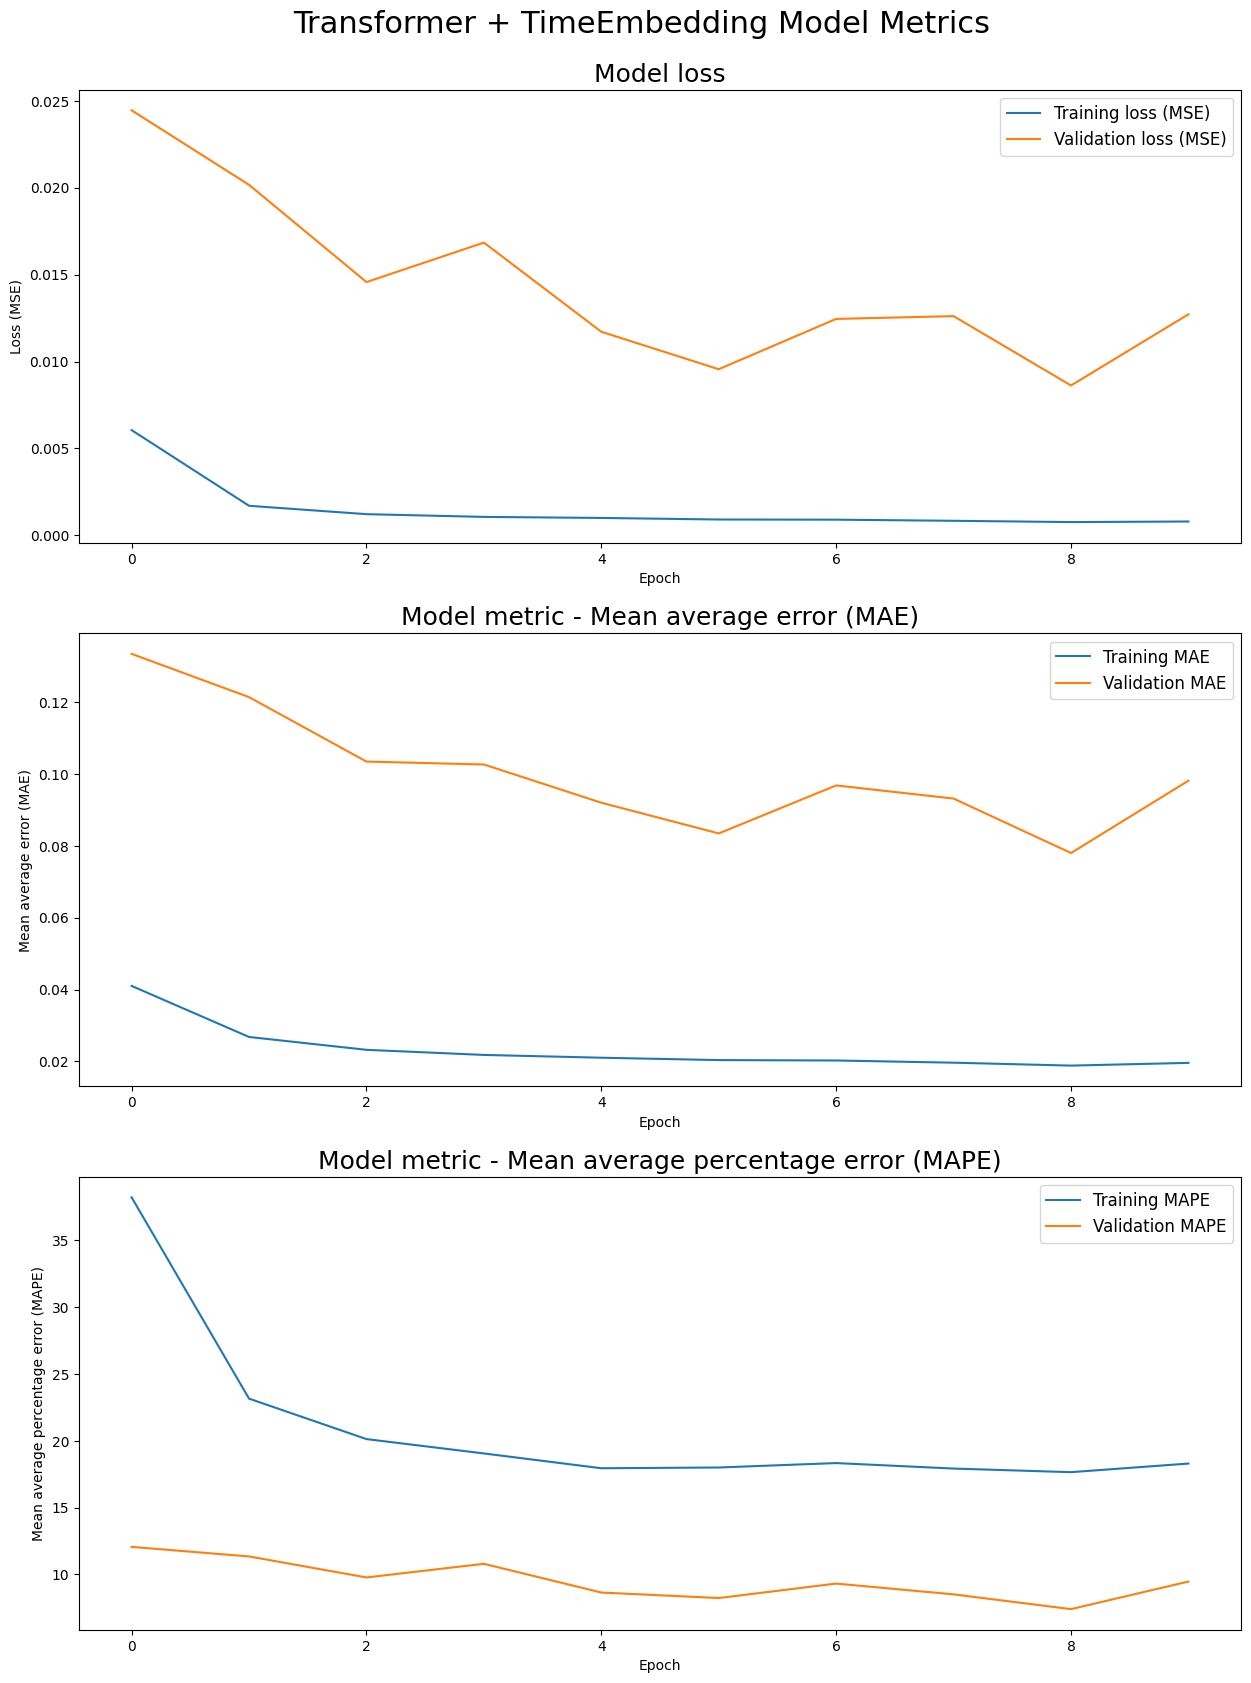

In [15]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

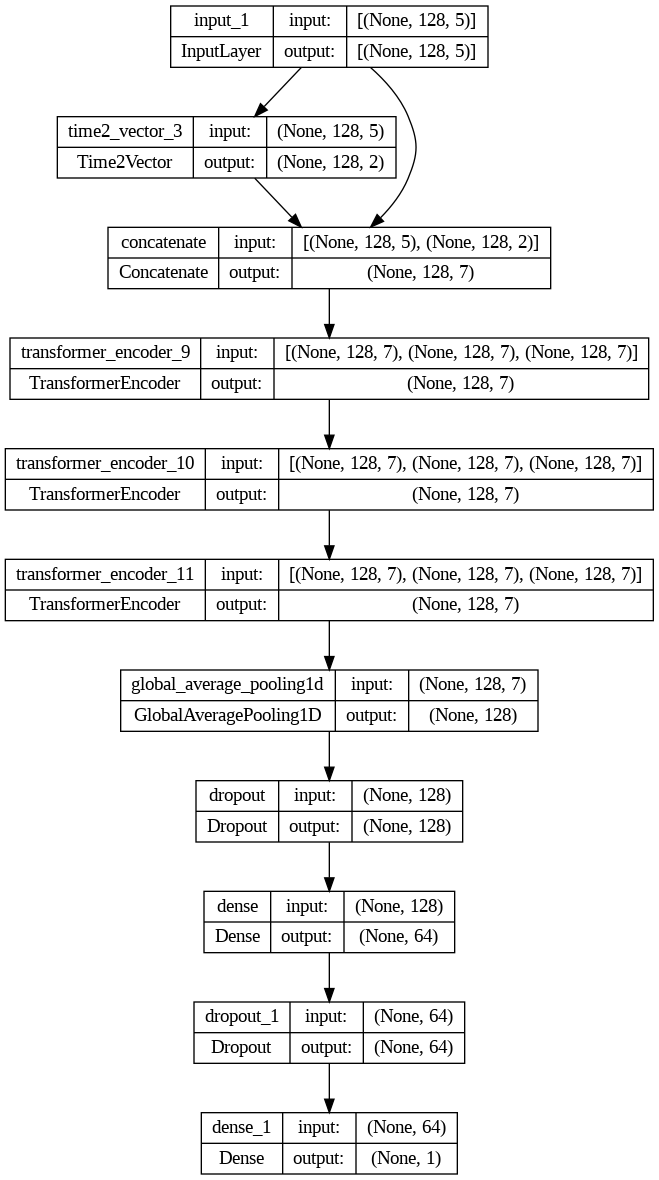

In [17]:
model=load_model('/content/Transformer+TimeEmbedding.hdf5',custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})
tf.keras.utils.plot_model(
    model,
    to_file="IBM_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

In [18]:
predicted_stock_price = model.predict(X_test)
y_test_n=y_test*(max_return -min_return)+min_return
predicted_stock_price_n=predicted_stock_price*(max_return -min_return)+min_return

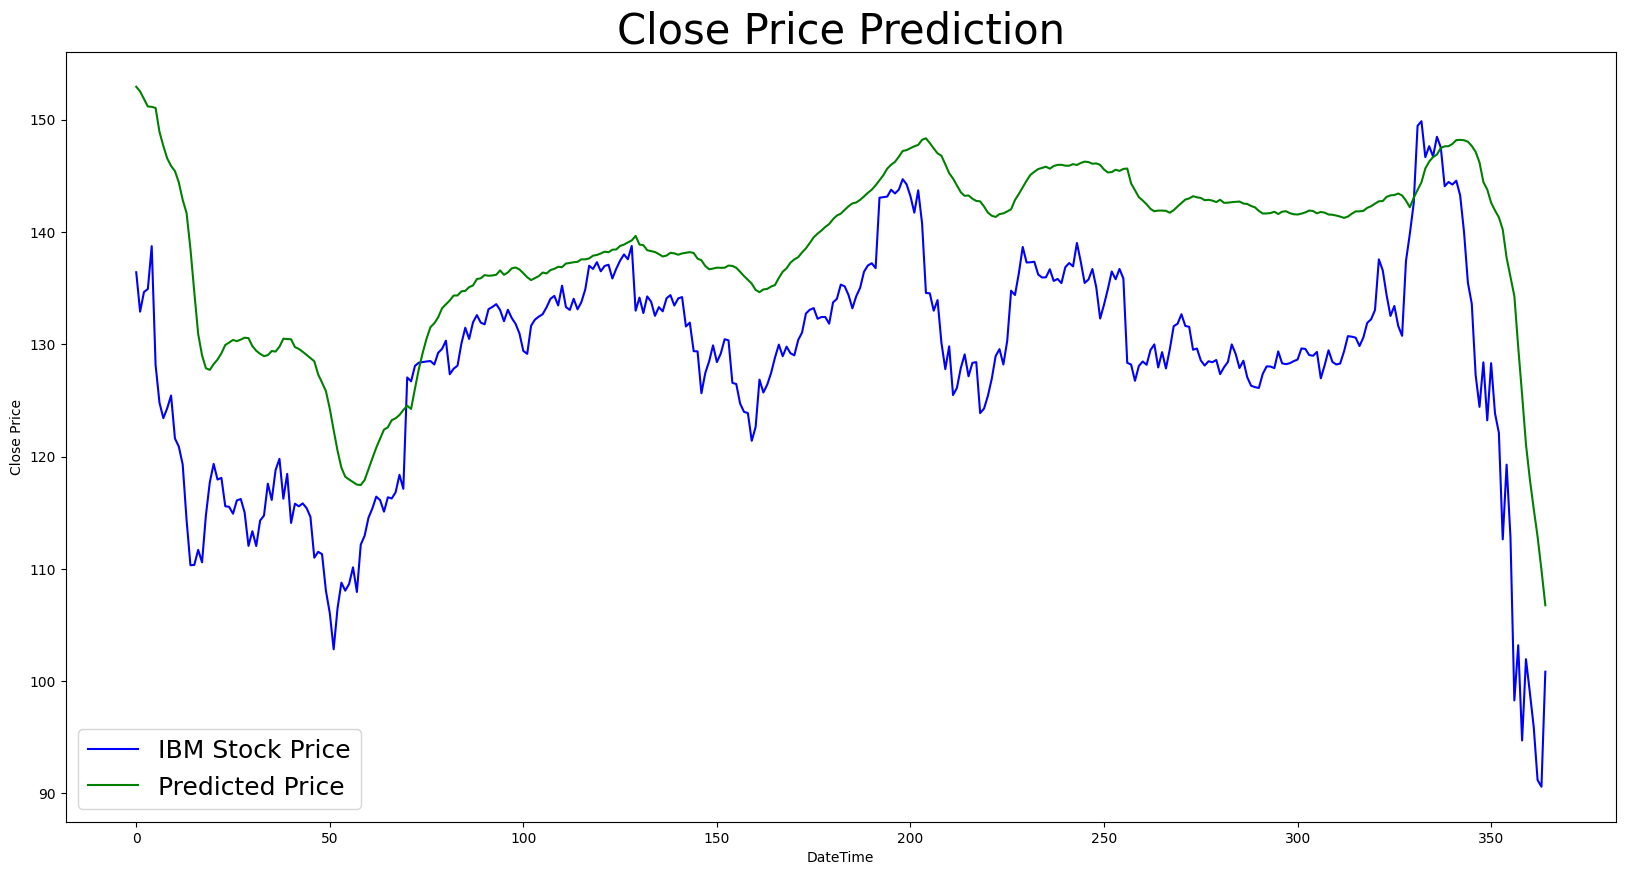

In [19]:
ig = plt.figure(figsize=(20,10))
plt.plot(y_test_n[225:590], color = 'blue', label = 'IBM Stock Price')
plt.plot(predicted_stock_price_n[225:590,0], color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
# plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [20]:
df = pd.read_csv("/content/stockdata/BTC-USD.csv")

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df.drop('Adj Close', inplace=True, axis=1)
df.sort_values('Date', inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume
3217,2023-07-09,30291.611328,30427.589844,30085.591797,30171.234375,7903327692
3218,2023-07-10,30172.423828,31026.083984,29985.394531,30414.470703,14828209155
3219,2023-07-11,30417.632813,30788.314453,30358.097656,30620.951172,12151839152
3220,2023-07-12,30622.246094,30959.964844,30228.835938,30391.646484,14805659717
3221,2023-07-13,30389.056641,30670.033203,30271.787109,30670.033203,13069927424


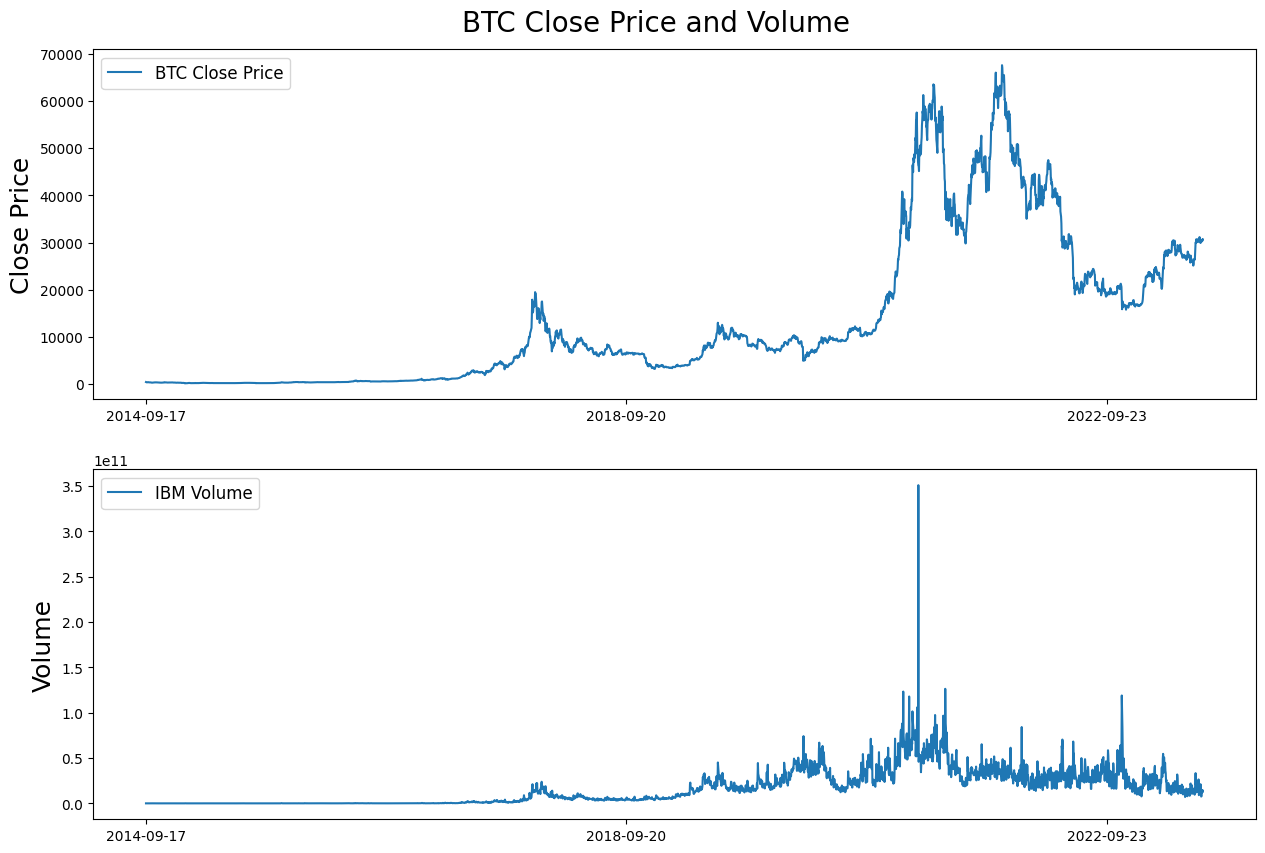

In [21]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("BTC Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='BTC Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='IBM Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [22]:
min_return = min(df[df.index>0][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[df.index>0][['Open', 'High', 'Low', 'Close']].max(axis=0))
print(min_return);
print(max_return);

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###########################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
df_test = df
df_test.drop(columns=['Date'], inplace=True)
# Convert pandas columns into arrays
df=df.values
test_data = df_test.values

print('Test data shape: {}'.format(test_data.shape))
df_test.head()

171.509995
68789.625
Test data shape: (3222, 5)


,Open,High,Low,Close,Volume
0,0.004290,0.004323,0.004094,0.004165,0.000043
1,0.004159,0.004159,0.003521,0.003686,0.000081
2,0.003681,0.003736,0.003104,0.003254,0.000091
3,0.003252,0.003669,0.003182,0.003460,0.000088
4,0.003448,0.003511,0.003231,0.003313,0.000059


In [23]:
# X_train, y_train = [], []
# for i in range(seq_len, len(train_data)):
#   X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
#   y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
# X_train, y_train = np.array(X_train), np.array(y_train)

# ###############################################################################

# # Validation data
# X_val, y_val = [], []
# for i in range(seq_len, len(val_data)):
#     X_val.append(val_data[i-seq_len:i])
#     y_val.append(val_data[:, 3][i])
# X_val, y_val = np.array(X_val), np.array(y_val)

# ###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (12262, 128, 5) (12262,)
Validation set shape (1421, 128, 5) (1421,)
Testing set shape (3094, 128, 5) (3094,)


In [24]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price

array([[0.00845682],
       [0.00845737],
       [0.00845781],
       ...,
       [0.43028516],
       [0.43067265],
       [0.4309641 ]], dtype=float32)

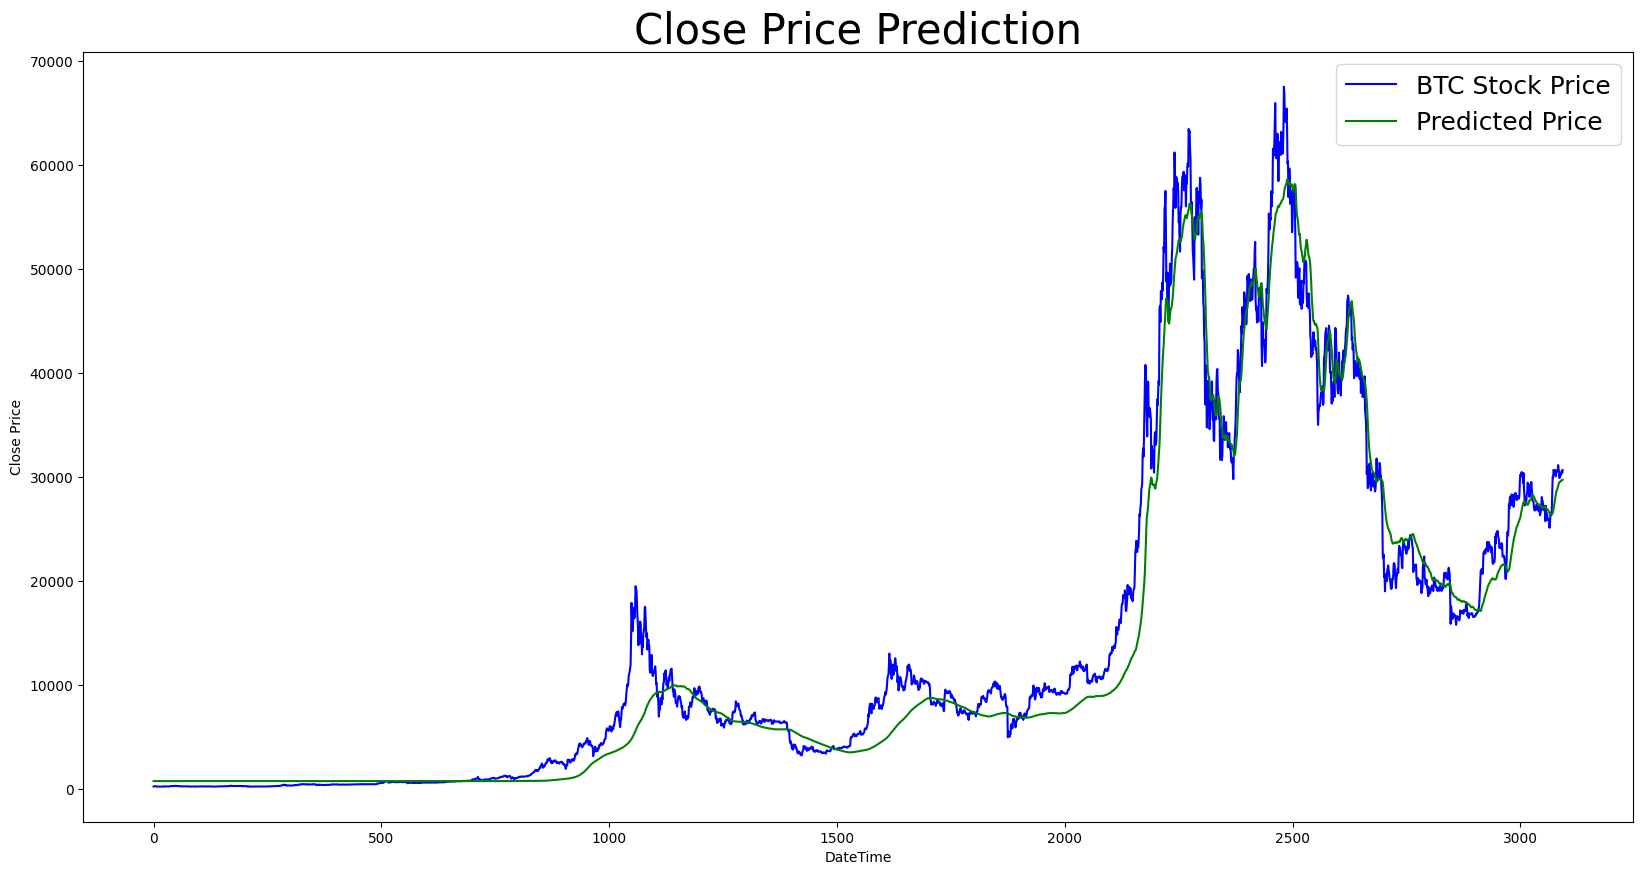

In [25]:
y_test_n=y_test*(max_return -min_return)+min_return
predicted_stock_price_n=predicted_stock_price*(max_return -min_return)+min_return
fig = plt.figure(figsize=(20,10))
plt.plot(y_test_n, color = 'blue', label = 'BTC Stock Price')
plt.plot(predicted_stock_price_n, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
# plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

0.998667
414.496674
Test data shape: (3282, 5)
Training set shape (12262, 128, 5) (12262,)
Validation set shape (1421, 128, 5) (1421,)
Testing set shape (3154, 128, 5) (3154,)


array([[0.00851913],
       [0.00851289],
       [0.00850477],
       ...,
       [0.64408773],
       [0.6460149 ],
       [0.6490374 ]], dtype=float32)

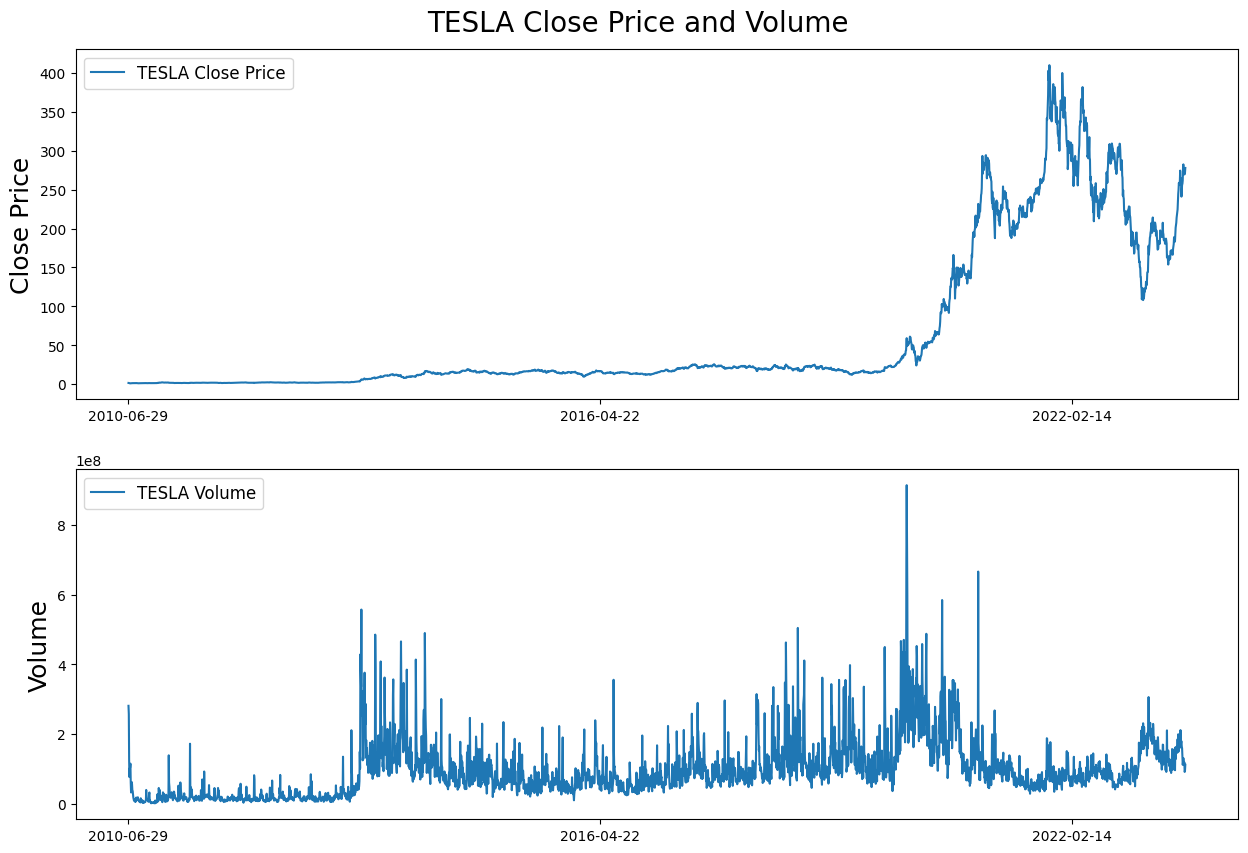

In [26]:
df = pd.read_csv("/content/stockdata/TSLA.csv")

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df.drop('Adj Close', inplace=True, axis=1)
df.sort_values('Date', inplace=True)
df.tail()
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("TESLA Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='TESLA Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='TESLA Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

min_return = min(df[df.index>0][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[df.index>0][['Open', 'High', 'Low', 'Close']].max(axis=0))
print(min_return);
print(max_return);

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###########################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
df_test = df
df_test.drop(columns=['Date'], inplace=True)
# Convert pandas columns into arrays
df=df.values
test_data = df_test.values

print('Test data shape: {}'.format(test_data.shape))
df_test.head()

X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

predicted_stock_price = model.predict(X_test)
predicted_stock_price



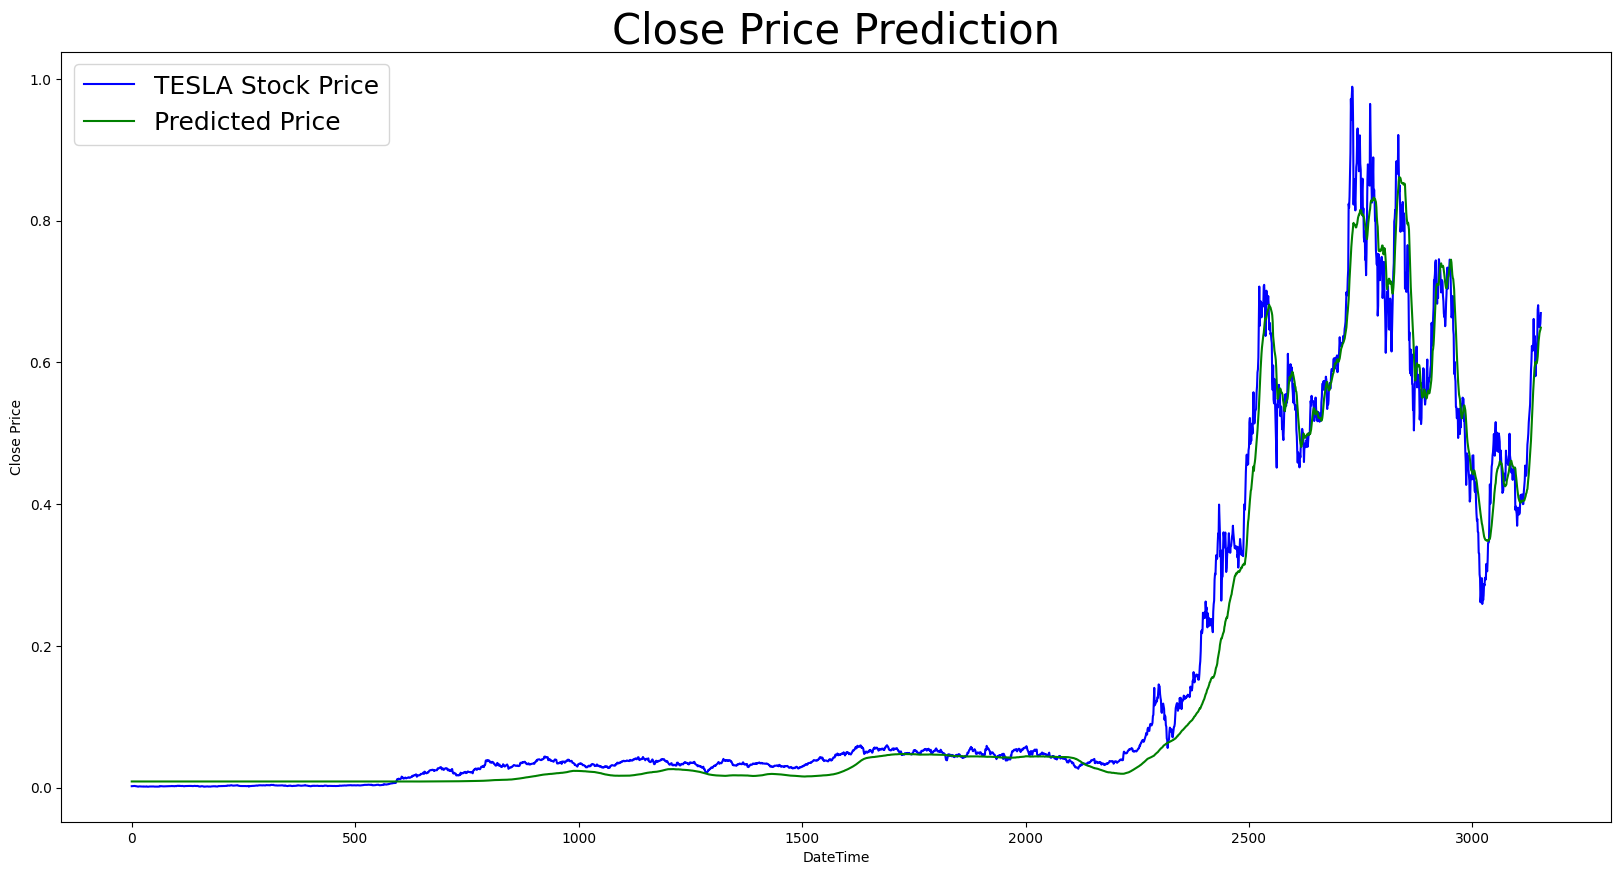

In [27]:
fig = plt.figure(figsize=(20,10))
plt.plot(y_test, color = 'blue', label = 'TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
# plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

0.049107
194.479996
Test data shape: (10736, 5)
Training set shape (12262, 128, 5) (12262,)
Validation set shape (1421, 128, 5) (1421,)
Testing set shape (10608, 128, 5) (10608,)


array([[0.00851204],
       [0.00851125],
       [0.00851117],
       ...,
       [0.947704  ],
       [0.9497615 ],
       [0.9513235 ]], dtype=float32)

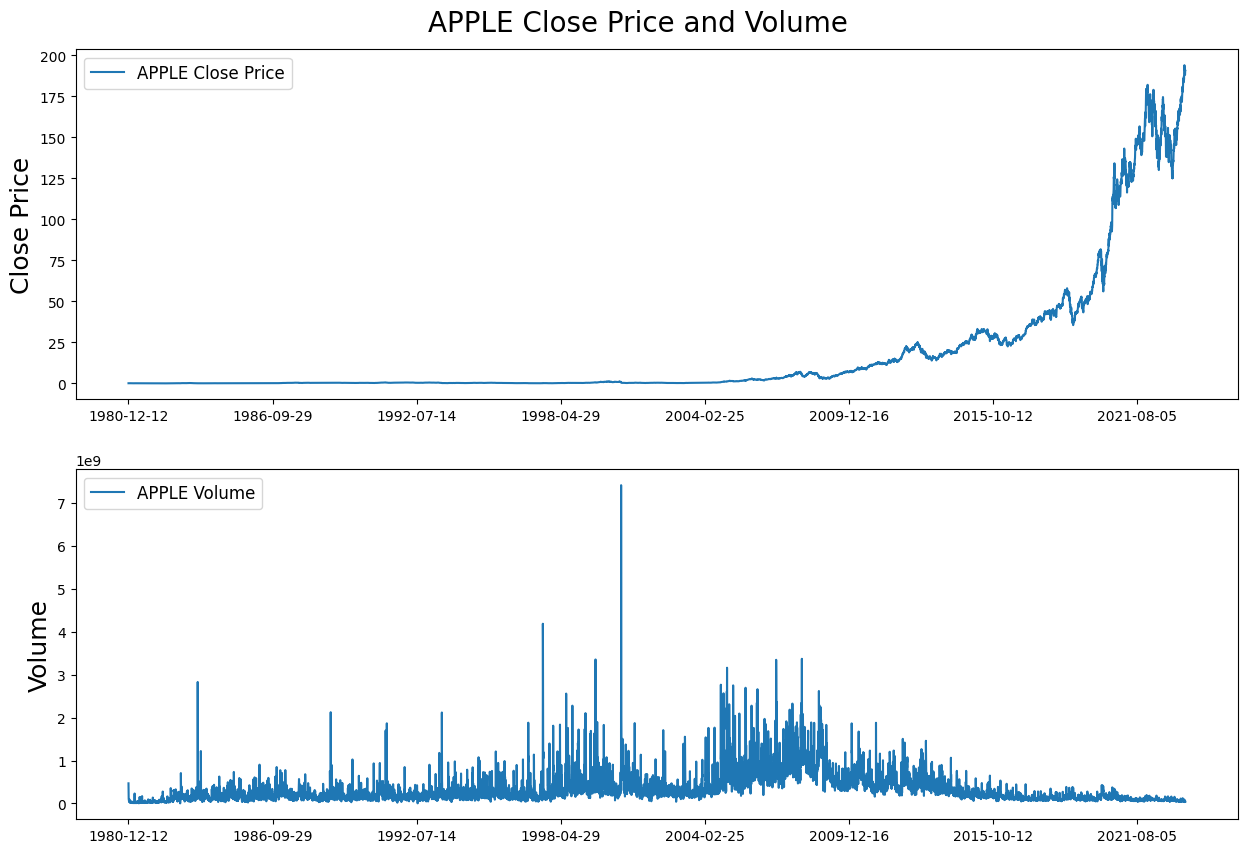

In [28]:
df = pd.read_csv("/content/stockdata/AAPL.csv")

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df.drop('Adj Close', inplace=True, axis=1)
df.sort_values('Date', inplace=True)
df.tail()
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("APPLE Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='APPLE Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='APPLE Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

min_return = min(df[df.index>0][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[df.index>0][['Open', 'High', 'Low', 'Close']].max(axis=0))
print(min_return);
print(max_return);

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###########################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
df_test = df
df_test.drop(columns=['Date'], inplace=True)
# Convert pandas columns into arrays
df=df.values
test_data = df_test.values

print('Test data shape: {}'.format(test_data.shape))
df_test.head()

X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

predicted_stock_price = model.predict(X_test)
predicted_stock_price



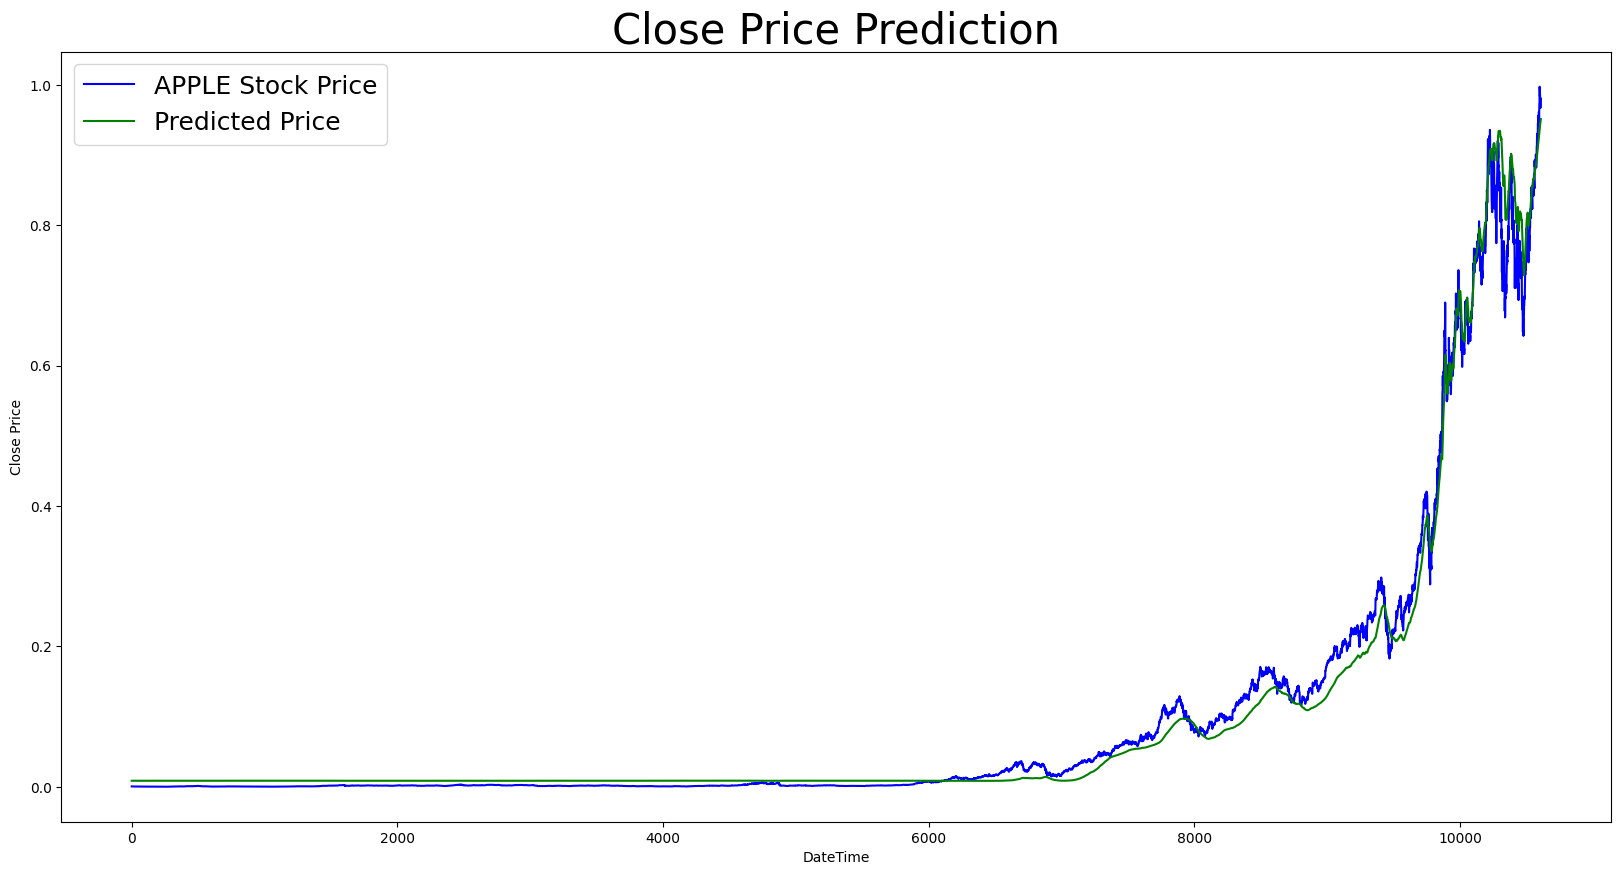

In [29]:
fig = plt.figure(figsize=(20,10))
plt.plot(y_test, color = 'blue', label = 'APPLE Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
# plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

2.464263
152.100006
Test data shape: (4758, 5)
Training set shape (12262, 128, 5) (12262,)
Validation set shape (1421, 128, 5) (1421,)
Testing set shape (4630, 128, 5) (4630,)


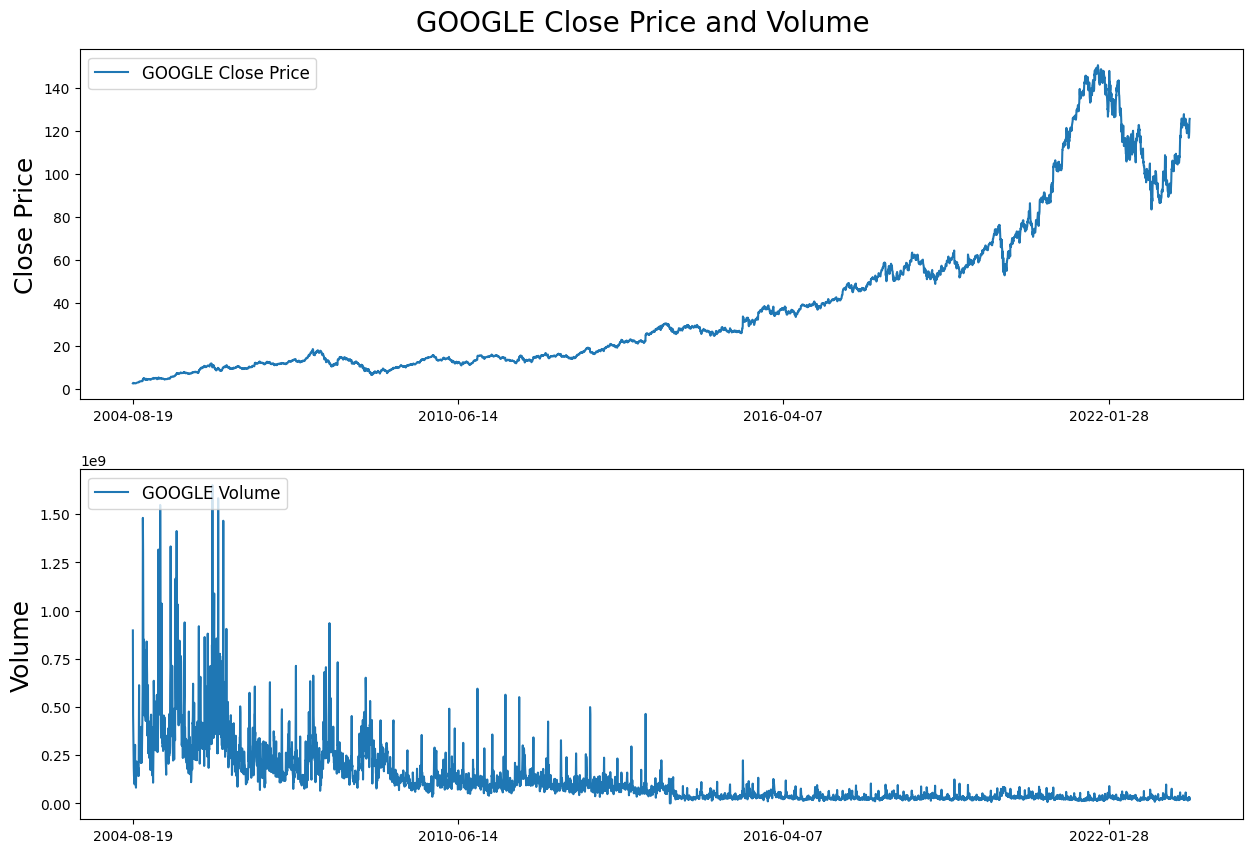

In [30]:
df = pd.read_csv("/content/stockdata/GOOG.csv")

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df.drop('Adj Close', inplace=True, axis=1)
df.sort_values('Date', inplace=True)
df.tail()
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("GOOGLE Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='GOOGLE Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='GOOGLE Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

min_return = min(df[df.index>0][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[df.index>0][['Open', 'High', 'Low', 'Close']].max(axis=0))
print(min_return);
print(max_return);

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###########################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
df_test = df
df_test.drop(columns=['Date'], inplace=True)
# Convert pandas columns into arrays
df=df.values
test_data = df_test.values

print('Test data shape: {}'.format(test_data.shape))
df_test.head()

X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

predicted_stock_price = model.predict(X_test)

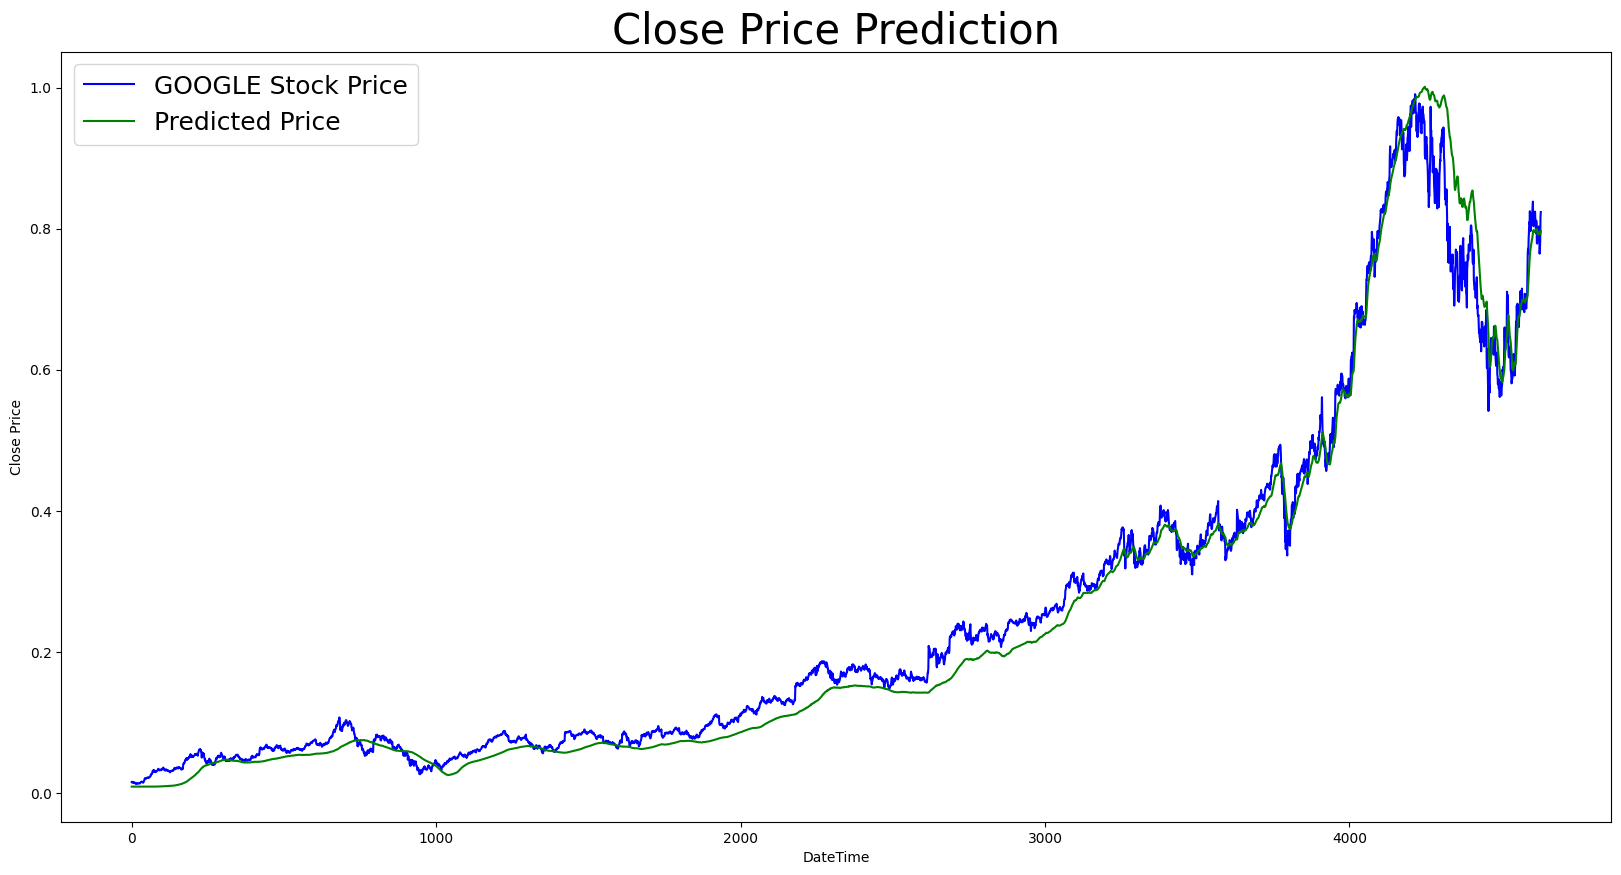

In [31]:
ig = plt.figure(figsize=(20,10))
plt.plot(y_test, color = 'blue', label = 'GOOGLE Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
# plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

0.065625
188.654007
Test data shape: (6584, 5)
Training set shape (12262, 128, 5) (12262,)
Validation set shape (1421, 128, 5) (1421,)
Testing set shape (6456, 128, 5) (6456,)


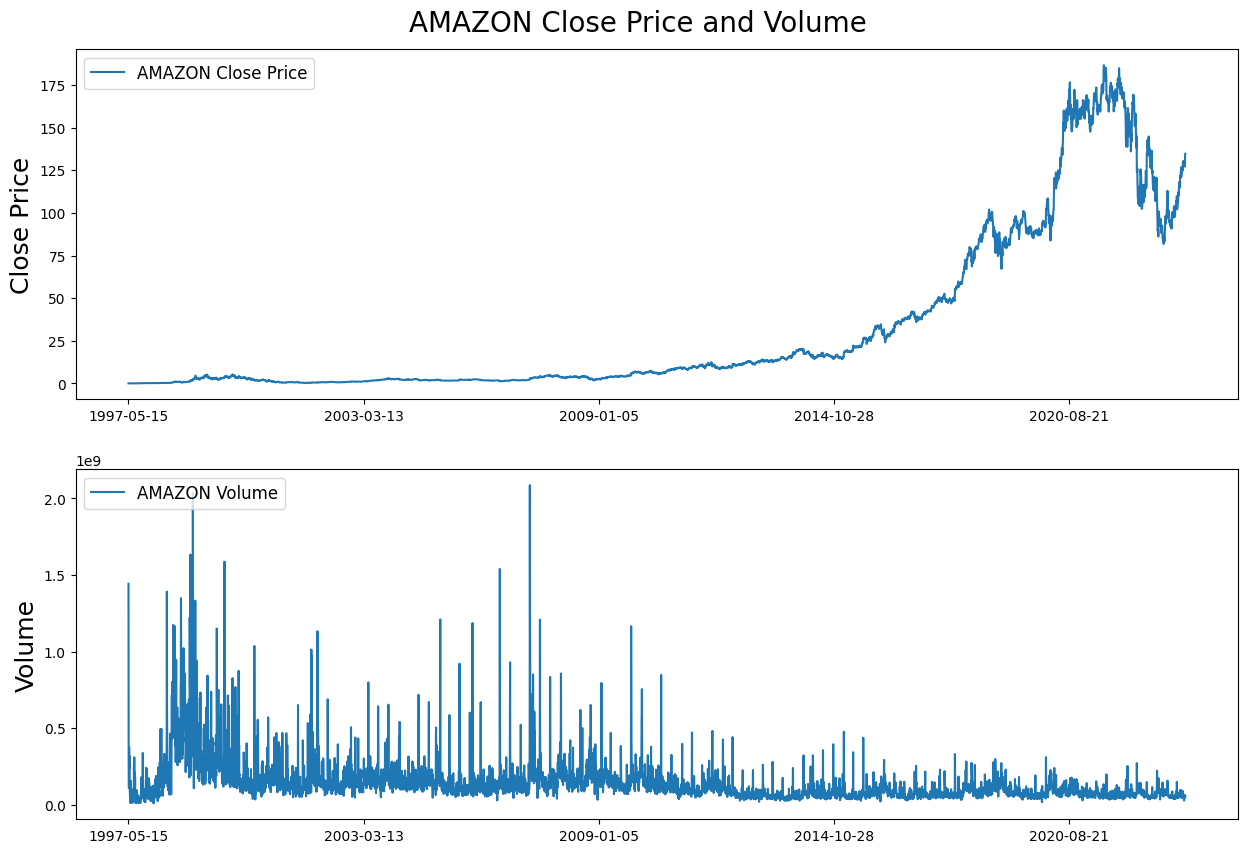

In [32]:
df = pd.read_csv("/content/stockdata/AMZN.csv")

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df.drop('Adj Close', inplace=True, axis=1)
df.sort_values('Date', inplace=True)
df.tail()
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("AMAZON Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='AMAZON Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='AMAZON Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

min_return = min(df[df.index>0][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[df.index>0][['Open', 'High', 'Low', 'Close']].max(axis=0))
print(min_return);
print(max_return);

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###########################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
df_test = df
df_test.drop(columns=['Date'], inplace=True)
# Convert pandas columns into arrays
df=df.values
test_data = df_test.values

print('Test data shape: {}'.format(test_data.shape))
df_test.head()

X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

predicted_stock_price = model.predict(X_test)

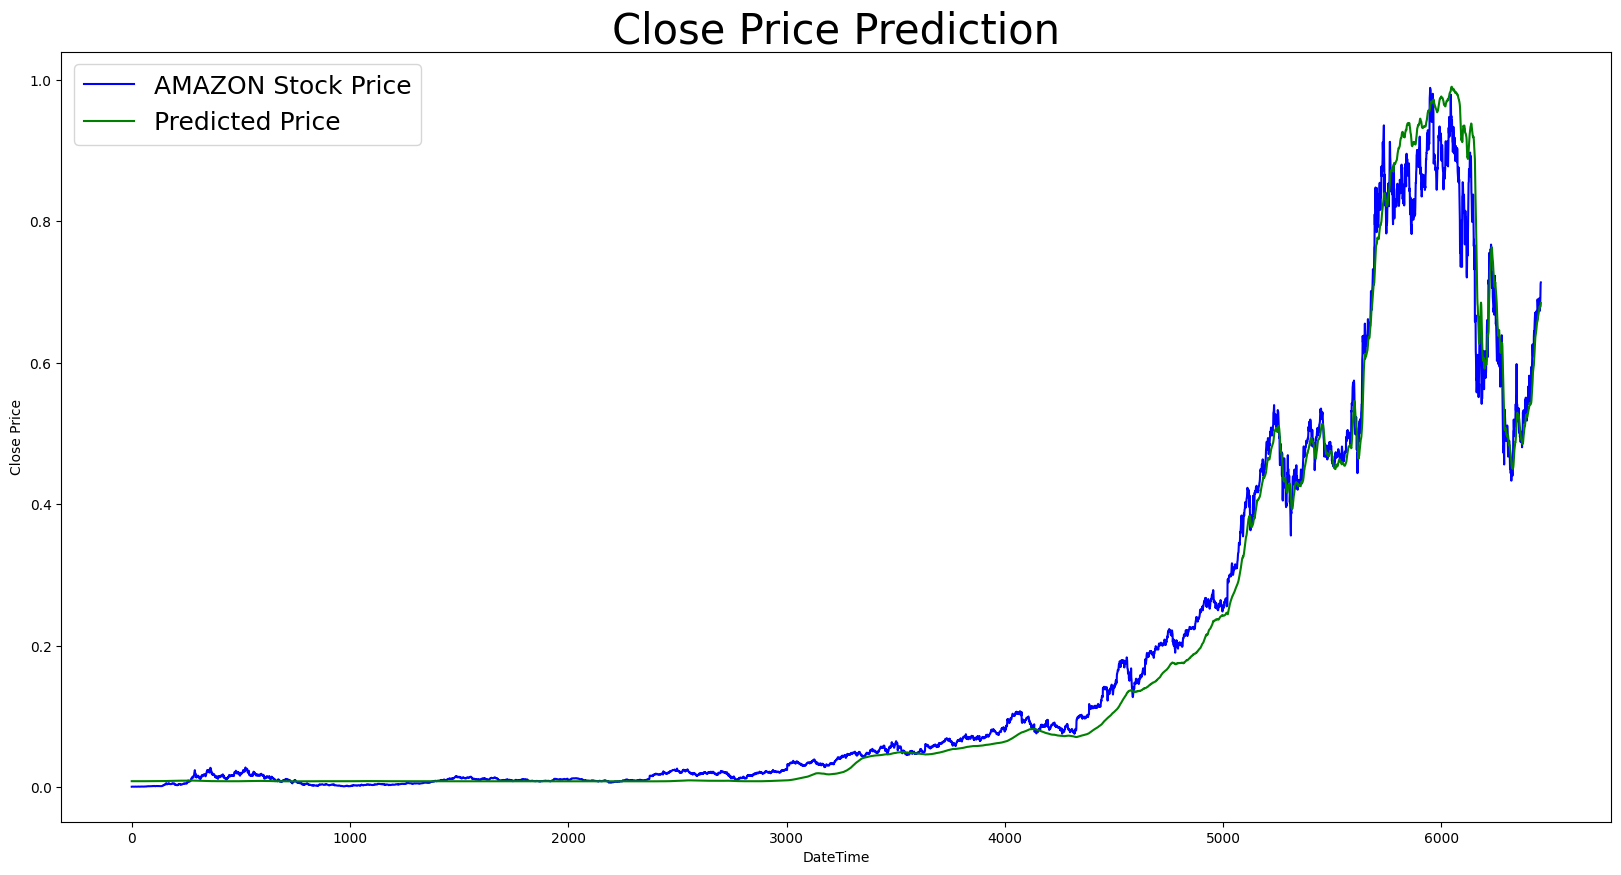

In [33]:
ig = plt.figure(figsize=(20,10))
plt.plot(y_test, color = 'blue', label = 'AMAZON Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
# plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

53.0
2070.0
Test data shape: (5639, 5)
Training set shape (12262, 128, 5) (12262,)
Validation set shape (1421, 128, 5) (1421,)
Testing set shape (5511, 128, 5) (5511,)


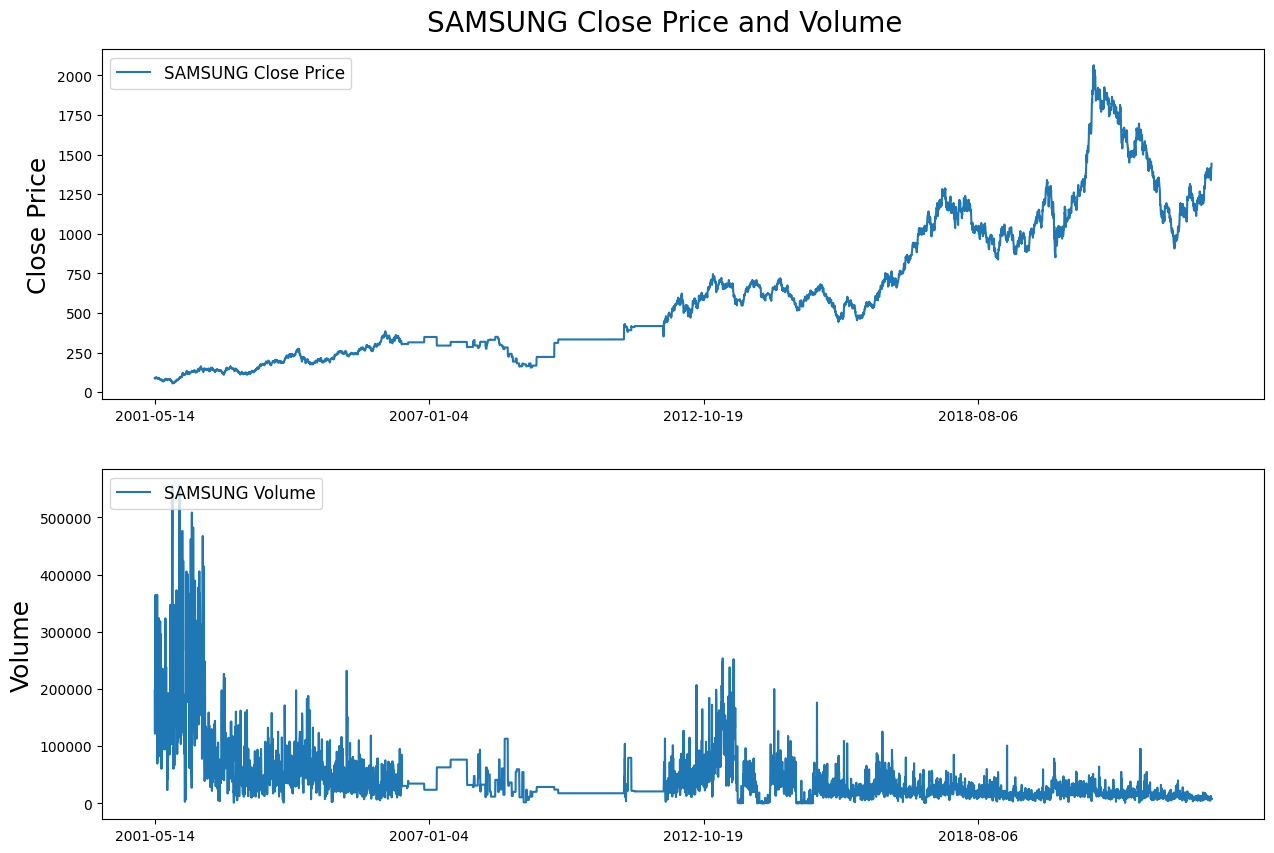

In [34]:
df = pd.read_csv("/content/stockdata/SMSN.IL.csv")

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df.drop('Adj Close', inplace=True, axis=1)
df.sort_values('Date', inplace=True)
df.tail()
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("SAMSUNG Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='SAMSUNG Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='SAMSUNG Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

min_return = min(df[df.index>0][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[df.index>0][['Open', 'High', 'Low', 'Close']].max(axis=0))
print(min_return);
print(max_return);

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###########################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
df_test = df
df_test.drop(columns=['Date'], inplace=True)
# Convert pandas columns into arrays
df=df.values
test_data = df_test.values

print('Test data shape: {}'.format(test_data.shape))
df_test.head()

X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

predicted_stock_price = model.predict(X_test)

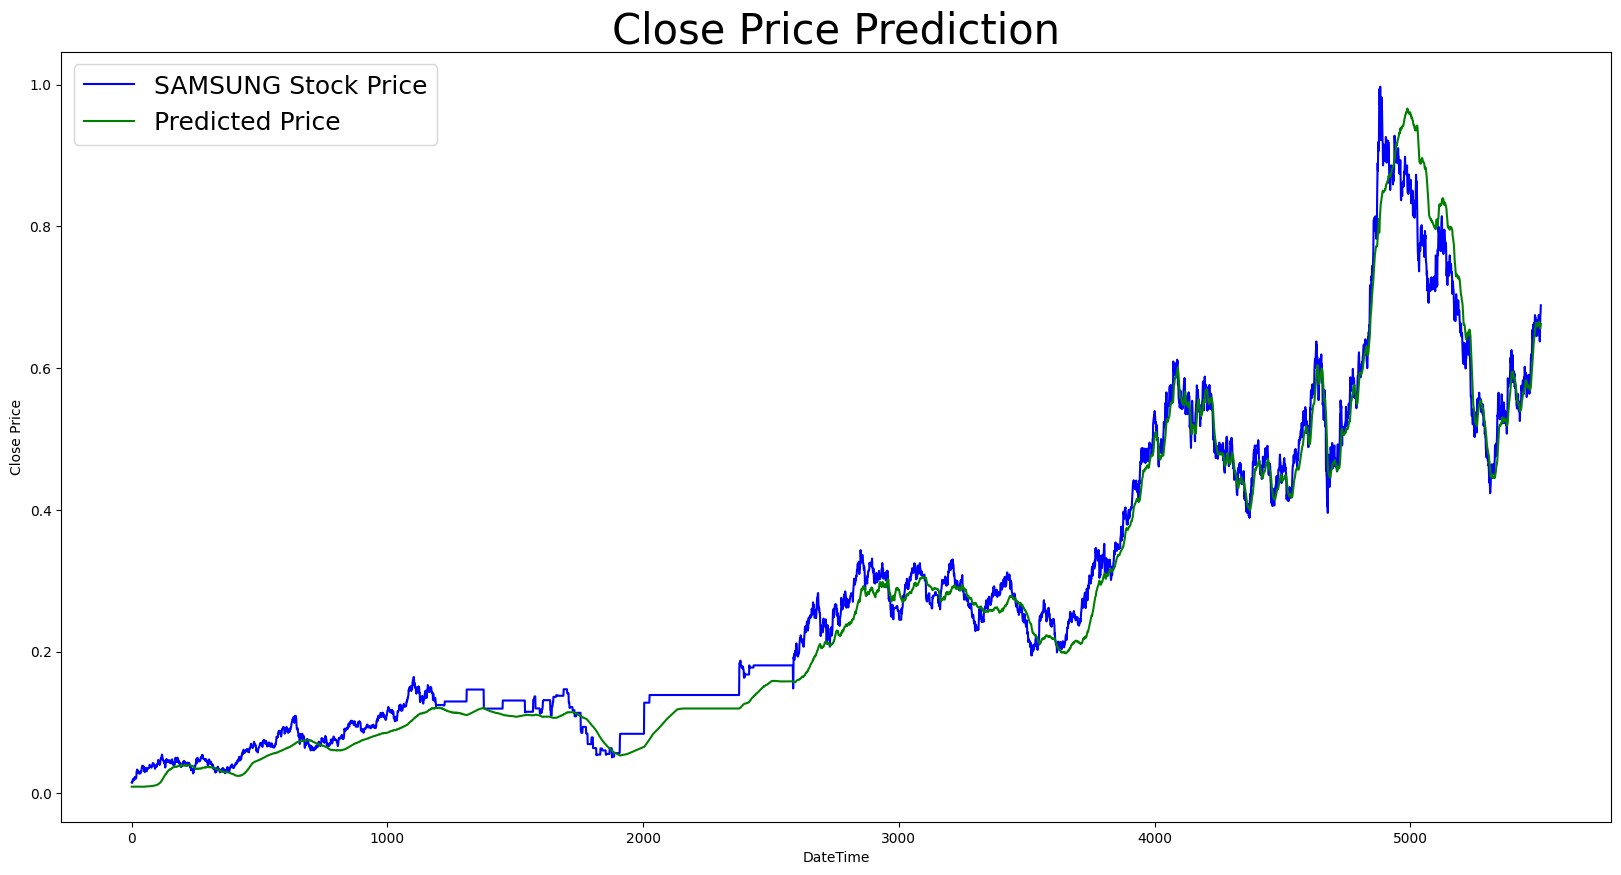

In [35]:
ig = plt.figure(figsize=(20,10))
plt.plot(y_test, color = 'blue', label = 'SAMSUNG Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
# plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()